## **Segmentacion de Clientes**

El conjunto de datos contiene transacciones desde el 1 de diciembre de 2010 hasta el 9 de diciembre de 2011 para un negocio minorista online con sede en UK.
Cada fila representa la transacción que ocurre.

Incluye el nombre del producto, la cantidad, el precio y otras columnas que representan la identificación.

Para la segmentación de clientes se utilizará **K-means**.

_"El algoritmo k-means es un algoritmo de optimización cuyo objetivo es minimizar la suma de distancias cuadráticas de cada observación al centroide de su clúster."_



- Definición

El algoritmo k-means es un método de agrupamiento que divide un conjunto de **n** observaciones en **k** grupos distintos gracias a valores medios. Pertenece al ámbito de los algoritmos no supervisados, ya que las observaciones no cuentan con una etiqueta que nos diga de qué grupo es cada dato.

El agrupamiento de las **n** observaciones en los **k** grupos distintos se realiza minimizando la suma de distancias entre cada observación y el centroide de su grupo. La distancia más común es la distancia euclídea.

**Funcionamiento de K-means**

Tres pasos:
- 1: **Inicialización**: una vez escogido **k** (número de grupos), se establecen los centroides en el espacio de los datos (asignando los k puntos aleatoriamente).

- 2: **Asignación de las observaciones a los centroides**: cada observación es asignada al centroide más cercano a ella usando la medida de distancia que se determine. 

- 3: **Actualización de los centroides**: se actualiza la posición de los centroides de cada grupo tomando como posición la media de la localización de las observaciones de dicho grupo.


Se repiten los pasos 2 y 3 hasta que los centroides se quedan fijos, o se mueven por debajo de una distancia umbral fijada. Este umbral esta determinado por la cantidad de iteraciones y de acuerdo a la distancia utilizada (euclidiana, Manhattan, Correlación de Pearson o Correlación de Coseno).





In [1]:
# Importacion de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
# warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_excel('df_retail.xlsx')

In [4]:
# eliminamos los NA
df = df[df['CustomerID'].notna()]

# dimension de la df
print(df.shape)

df.head(5)

(406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
#formato de los datos
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

**Tabla RFM**

Para segmentar a los clientes, hay algunas métricas que podemos usar.

- **R**: cuándo el cliente compró el producto por última vez.
- **F**: con qué frecuencia compra el producto
- **M**: cuánto paga el cliente por el producto. 

Para obtener el número de días para la columna **R**, podemos restar la fecha de la instantánea con la fecha en la que se produjo la transacción.

Para la frecuencia **F**, podemos contar la cantidad de transacciones de cada cliente.

Por último, para crear la columna de valor monetario **M**, podemos sumar todas las transacciones de cada cliente.


In [6]:
# para mostrar solo la fecha
from datetime import datetime
df["InvoiceDate"] = df["InvoiceDate"].dt.date

#columna Suma total
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# variable fecha que registre la actualidad
import datetime
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1)

# Datos agregados por cada cliente
customers = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalSum': 'sum'})

# renombramos columnas
customers.rename(columns = {'InvoiceDate': 'Recencia',
                            'InvoiceNo': 'Frecuencia',
                            'TotalSum': 'Valor'}, inplace=True)

In [7]:
customers.head(5)

,Recencia,Frecuencia,Valor
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


**Asimetría y Escalado**

Tenemos que asegurarnos de que los datos cumplan con estos supuestos.

_"Los datos deben cumplir supuestos donde las variables no están sesgadas y tienen la misma media y varianza."_


- **Asimetría**

Hay algunos métodos que podemos usar para manejar la asimetría:
- Log Transformation
- Square Root Transformation
- Box-Cox Transformation

Nota: Podemos usar la transformación si la variable solo tiene valores positivos.

Se analizará la simetria de cada variable y se realizará una transformación para observar los cambios.

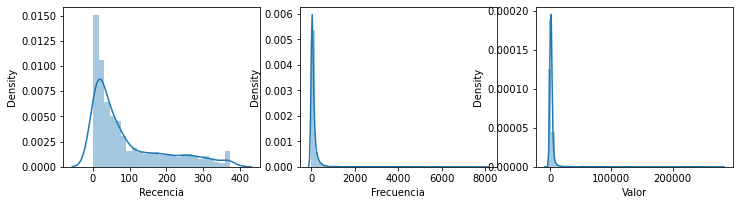

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,10))
for i, column in enumerate(customers.columns, 1):
    plt.subplot(3,3,i)
    sns.distplot(customers[column])
plt.show();


**Transformaciones**

- Log
- sqrt
- boxcox



In [9]:
# analisis de asimetria.

# Por cada variable se establece la transformacion boxcox, log, sqrt y sin transformacion.
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

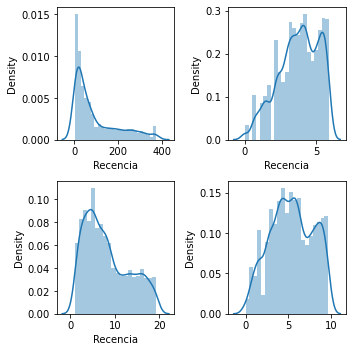

1.25
-0.45
0.6
-0.07


In [10]:
# Análisis Recencia
analyze_skewness('Recencia')

# se observa que la mejor transformacion es por medio de Boxcox (mejor asimetría).

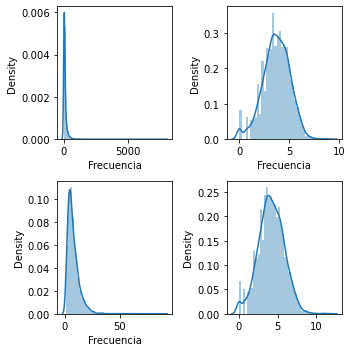

18.15
-0.24
3.2
0.0


In [132]:
#Frecuencia
analyze_skewness('Frecuencia')
# se observa que la mejor transformacion es por medio de Boxcox

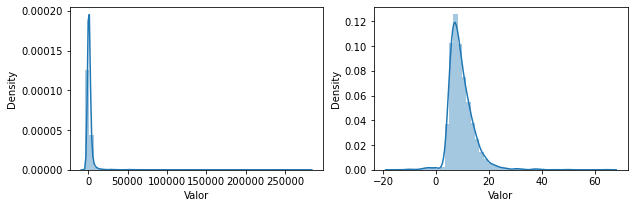

21.71
2.29


In [135]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['Valor'], ax=ax[0])
sns.distplot(np.cbrt(customers['Valor']), ax=ax[1])
plt.show()
print(customers['Valor'].skew().round(2))
print(np.cbrt(customers['Valor']).skew().round(2))

In [136]:
pd.Series(np.cbrt(customers['Valor'])).values

array([ 0.        , 16.27392924, 12.15818345, ...,  5.61043971,
       12.79537593, 12.24781024])

**Transformación Boxcox**

Las transformaciones de Box y Cox son una familia de transformaciones potenciales usadas en estadística para corregir sesgos en la distribución de errores, para corregir **varianzas desiguales** y principalmente para **corregir la no linealidad en la relación**. Por tanto, es una transformación de variables dependientes no normales en una forma normal . 

La normalidad es una suposición importante para muchas técnicas estadísticas; si sus datos no son normales, aplicar un Box-Cox significa se puede ejecutar una mayor cantidad de pruebas. 



In [11]:
# Utilizacion de la transformacion de Box-Cox

from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recencia"] = stats.boxcox(customers['Recencia'])[0]
customers_fix["Frecuencia"] = stats.boxcox(customers['Frecuencia'])[0]
customers_fix["Valor"] = pd.Series(np.cbrt(customers['Valor'])).values
customers_fix.tail()

,Recencia,Frecuencia,Valor
4367,8.932980,2.460908,5.652483
4368,7.949051,2.058202,4.323541
4369,2.449000,2.762414,5.610440
4370,1.544575,8.057611,12.795376
4371,5.087438,4.808490,12.247810


In [13]:
customers_fix.describe()

# se observa que las variables presentan distintos valores para la media y var.

,Recencia,Frecuencia,Valor
count,4372.000000,4372.000000,4372.000000
mean,5.365902,4.163558,9.624086
std,2.458295,1.647655,4.998417
min,0.000000,0.000000,-16.245725
25%,3.547952,3.075409,6.644590
50%,5.395110,4.166739,8.653831
75%,7.450548,5.293594,11.724572
max,9.651959,11.742237,65.381506


**Normalizacion**

Cada variable no tiene la misma media y varianza, por tanto, tenemos que normalizarlo. 

Para normalizar, podemos usar el objeto StandardScaler de la biblioteca scikit-learn para hacerlo.

In [15]:
# Normalizacion
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)# debe tener mean=0 y var=1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0. -0.]
[1. 1. 1.]


In [16]:
pd.DataFrame(customers_normalized).head(5)

,0,1,2
0,1.606608,-2.098072,-1.925647
1,-1.696240,1.151346,1.330542
2,0.317615,-0.224316,0.507038
3,-0.669146,0.423978,0.488997
4,1.560253,-0.660498,-0.536848


In [39]:
pd.DataFrame(customers_normalized).describe()

# podemos observar despues de la normalizacion otorga que la media = 0 y var = 1

,0,1,2
count,4.372000e+03,4.372000e+03,4.372000e+03
mean,-5.651104e-17,7.487403e-17,-1.754467e-16
std,1.000114e+00,1.000114e+00,1.000114e+00
min,-2.183023e+00,-2.527249e+00,-5.176193e+00
25%,-7.396007e-01,-6.604983e-01,-5.961562e-01
50%,1.188276e-02,1.930865e-03,-1.941347e-01
75%,8.481018e-01,6.859230e-01,4.202781e-01
max,1.743707e+00,4.600201e+00,1.115629e+01


**Modelado**

Inmediatamente después de preprocesar los datos, ahora podemos centrarnos en el modelado. Para hacer la segmentación de los datos, podemos usar el algoritmo **K-Means** para hacer esto.

El algoritmo **K-Means** es un algoritmo de aprendizaje no supervisado que utiliza el principio geométrico para determinar qué grupo pertenece a los grupos.

Al determinar cada centroide, calculamos la distancia a cada centroide. Cada dato pertenece a un centroide si tiene la menor distancia del otro. Se repite hasta que el próximo total de la distancia no tenga cambios significativos que antes.


Para que nuestro agrupamiento alcance su máximo rendimiento, debemos determinar qué hiperparámetro se ajusta a los datos. Para determinar qué hiperparámetro (**busqueda del K**) es el mejor para nuestro modelo y datos, podemos usar el **método del codo** para decidir.



**SSE**

Método utilizado para comparar el ajuste de las líneas es calcular el SSE (suma de los cuadrados de los errores o desviaciones) para cada línea. Cuanto menor sea el SSE, mejor será el ajuste de la línea a los datos.


**Método del Codo**

El método del codo utiliza la distancia media de las observaciones a su centroide. Es decir, se fija en las distancias intra-cluster. Cuanto más grande es el número de clusters **k**, la varianza intra-cluster tiende a disminuir. Cuanto menor es la distancia intra-cluster mejor, ya que significa que los clústers son más compactos. 

El método del codo busca el valor **k** que satisfaga que un incremento de **k**, no mejore sustancialmente la distancia media intra-cluster.

_Nota: El método del codo es a veces ambiguo, una alternativa es el **análisis de la silueta**, que es más objetivo que el método del codo._

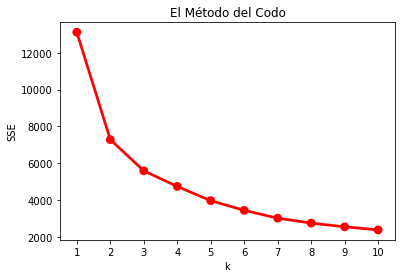

In [38]:
# Determinacion del K
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # El k mas cercano al centroide, vía el método del codo
plt.title('El Método del Codo')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()),color="red")
plt.show()

**Interpretación**

El eje x es el valor de k, y el eje y es el valor SSE de los datos. Tomaremos el mejor parámetro observando dónde el valor k tendrá una tendencia lineal en el siguiente k consecutivo.

Según nuestra observación, el valor **k** de **3** es el mejor hiperparámetro para nuestro modelo porque el siguiente valor **k** tiende a tener una tendencia lineal. Por lo tanto, nuestro mejor modelo para los datos es **K-Means** con un número de grupos de **3**.

In [19]:
# Modelado

modelo = KMeans(n_clusters=3, random_state=42)
modelo.fit(customers_normalized)
modelo.labels_.shape

(4372,)

In [20]:
customers.shape

(4372, 3)

In [21]:
customers["Cluster"] = modelo.labels_
customers.head()
print(customers.shape)

(4372, 4)


**Análisis de Cluster**

In [22]:
customers["Cluster"] = modelo.labels_
customers.head()

,Recencia,Frecuencia,Valor,Cluster
CustomerID,,,,
12346.0,326,2,0.00,0
12347.0,3,182,4310.00,2
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0


Podemos resumir la **tabla RFM** en base a conglomerados y calcular la media de cada variable.

In [23]:
customers.groupby('Cluster').agg({
    'Recencia':'mean',
    'Frecuencia':'mean',
    'Valor':['mean', 'count']}).round(1)

Recencia Frecuencia   Valor      
            mean       mean    mean count
Cluster                                  
0          185.3       19.2   352.1  1659
1           42.9       67.5  1008.3  1934
2           18.5      313.7  7401.7   779

**Gráfico Snake**

In [24]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recencia', 'Frecuencia', 'Valor'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = modelo.labels_
df_normalized.head()

,Recencia,Frecuencia,Valor,ID,Cluster
0,1.606608,-2.098072,-1.925647,12346.0,0
1,-1.696240,1.151346,1.330542,12347.0,2
2,0.317615,-0.224316,0.507038,12348.0,1
3,-0.669146,0.423978,0.488997,12349.0,1
4,1.560253,-0.660498,-0.536848,12350.0,0


In [25]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recencia','Frecuencia','Valor'],
                      var_name='Atributo',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Atributo,Value
0,12346.0,0,Recencia,1.606608
1,12347.0,2,Recencia,-1.696240
2,12348.0,1,Recencia,0.317615
3,12349.0,1,Recencia,-0.669146
4,12350.0,0,Recencia,1.560253


Podemos analizar los segmentos usando el diagrama de serpiente. Requiere el conjunto de datos normalizado y también las etiquetas de clúster. Al usar este gráfico, podemos tener una buena visualización de los datos sobre cómo el grupo difiere entre sí.

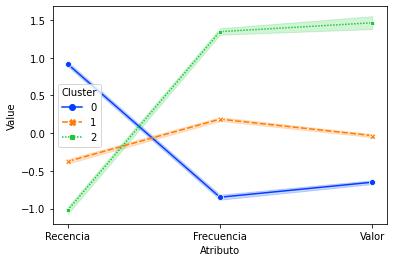

In [29]:
sns.lineplot('Atributo', 'Value', hue='Cluster', data=df_nor_melt, style="Cluster", markers=True,palette="bright");

Al usar esta gráfica, sabemos cómo difiere cada segmento.

- Inferimos que el **clúster 0** compran el producto recientemente, con menos frecuencia y pagando menores valores que los demás clusters. Por lo tanto, podría ser el clúster de un cliente fiel.

- Entonces, el **clúster 1** compra con una moderada frecuencia, con menor recencia que el cluster 0 y con valores moderados. Por lo tanto, podría ser el clúster de nuevos clientes.

- Finalmente, el **clúster 2** compra con grandes valores y frecuencias, pero no recientemente. Por lo tanto, podría ser el grupo de clientes agitados.

**Conclusión**

La segmentación de clientes es realmente necesaria para saber qué características existen en cada cliente.- 